In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import time
import matplotlib.pyplot as plt

In [3]:
batch_size = 1000
embed_dim = 64
hidden_size = 8
num_layers = 25
epochs = 5
max_len = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def yield_tokens(data_iter):
    for label, line in data_iter:
        yield tokenizer(line)

def process_text(text):
    tokens = tokenizer(text)
    token_ids = vocab(tokens)
    if len(token_ids) > max_len:
        token_ids = token_ids[:max_len]
    else:
        token_ids = token_ids + [0]*(max_len - len(token_ids))
    return torch.tensor(token_ids, dtype=torch.long)

def collate_fn(batch):
    texts, labels = [], []
    for label, text in batch:
        texts.append(process_text(text))
        labels.append(1 if label == 'pos' else 0)
    return torch.stack(texts), torch.tensor(labels, dtype=torch.float)

train_iter, test_iter = IMDB(split=('train', 'test'))

tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

train_loader = DataLoader(list(train_iter), batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(list(test_iter), batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [5]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size=1, num_layers=25):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        W_xh_layers = [nn.Parameter(torch.Tensor(embed_dim, hidden_size))]
        W_hh_layers = [nn.Parameter(torch.Tensor(hidden_size, hidden_size))]
        b_h_layers = [nn.Parameter(torch.Tensor(hidden_size))]

        for _ in range(num_layers - 1):
            W_xh_layers.append(nn.Parameter(torch.Tensor(hidden_size, hidden_size)))
            W_hh_layers.append(nn.Parameter(torch.Tensor(hidden_size, hidden_size)))
            b_h_layers.append(nn.Parameter(torch.Tensor(hidden_size)))

        self.W_xh_layers = nn.ParameterList(W_xh_layers)
        self.W_hh_layers = nn.ParameterList(W_hh_layers)
        self.b_h_layers = nn.ParameterList(b_h_layers)

        self.W_hy = nn.Parameter(torch.Tensor(hidden_size, output_size))
        self.b_y = nn.Parameter(torch.Tensor(output_size))

        self.reset_parameters()

    def reset_parameters(self):
        for i in range(self.num_layers):
            nn.init.kaiming_uniform_(self.W_xh_layers[i], a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.W_hh_layers[i], a=math.sqrt(5))
            nn.init.zeros_(self.b_h_layers[i])

        nn.init.kaiming_uniform_(self.W_hy, a=math.sqrt(5))
        nn.init.zeros_(self.b_y)

    def forward(self, x, h_0=None):
        batch_size, seq_len = x.size()
        if h_0 is None:
            h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)

        embedded = self.embedding(x)
        h_t_layers = [h_0[i] for i in range(self.num_layers)]

        for t in range(seq_len):
            input_t = embedded[:, t, :]
            for i in range(self.num_layers):
                h_t_layers[i] = torch.tanh(input_t @ self.W_xh_layers[i] + h_t_layers[i] @ self.W_hh_layers[i] + self.b_h_layers[i])
                input_t = h_t_layers[i]

        logits = input_t @ self.W_hy + self.b_y
        h_last = torch.stack(h_t_layers, dim=0)
        return logits.squeeze(1), h_last

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size=1, num_layers=25):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        W_xf_layers = [nn.Parameter(torch.Tensor(embed_dim, hidden_size))]
        W_hf_layers = [nn.Parameter(torch.Tensor(hidden_size, hidden_size))]
        b_f_layers = [nn.Parameter(torch.Tensor(hidden_size))]

        W_xi_layers = [nn.Parameter(torch.Tensor(embed_dim, hidden_size))]
        W_hi_layers = [nn.Parameter(torch.Tensor(hidden_size, hidden_size))]
        b_i_layers = [nn.Parameter(torch.Tensor(hidden_size))]

        W_xC_layers = [nn.Parameter(torch.Tensor(embed_dim, hidden_size))]
        W_hC_layers = [nn.Parameter(torch.Tensor(hidden_size, hidden_size))]
        b_C_layers = [nn.Parameter(torch.Tensor(hidden_size))]

        W_xo_layers = [nn.Parameter(torch.Tensor(embed_dim, hidden_size))]
        W_ho_layers = [nn.Parameter(torch.Tensor(hidden_size, hidden_size))]
        b_o_layers = [nn.Parameter(torch.Tensor(hidden_size))]

        for _ in range(num_layers - 1):
            W_xf_layers.append(nn.Parameter(torch.Tensor(hidden_size, hidden_size)))
            W_hf_layers.append(nn.Parameter(torch.Tensor(hidden_size, hidden_size)))
            b_f_layers.append(nn.Parameter(torch.Tensor(hidden_size)))

            W_xi_layers.append(nn.Parameter(torch.Tensor(hidden_size, hidden_size)))
            W_hi_layers.append(nn.Parameter(torch.Tensor(hidden_size, hidden_size)))
            b_i_layers.append(nn.Parameter(torch.Tensor(hidden_size)))

            W_xC_layers.append(nn.Parameter(torch.Tensor(hidden_size, hidden_size)))
            W_hC_layers.append(nn.Parameter(torch.Tensor(hidden_size, hidden_size)))
            b_C_layers.append(nn.Parameter(torch.Tensor(hidden_size)))

            W_xo_layers.append(nn.Parameter(torch.Tensor(hidden_size, hidden_size)))
            W_ho_layers.append(nn.Parameter(torch.Tensor(hidden_size, hidden_size)))
            b_o_layers.append(nn.Parameter(torch.Tensor(hidden_size)))

        self.W_xf_layers = nn.ParameterList(W_xf_layers)
        self.W_hf_layers = nn.ParameterList(W_hf_layers)
        self.b_f_layers = nn.ParameterList(b_f_layers)

        self.W_xi_layers = nn.ParameterList(W_xi_layers)
        self.W_hi_layers = nn.ParameterList(W_hi_layers)
        self.b_i_layers = nn.ParameterList(b_i_layers)

        self.W_xC_layers = nn.ParameterList(W_xC_layers)
        self.W_hC_layers = nn.ParameterList(W_hC_layers)
        self.b_C_layers = nn.ParameterList(b_C_layers)

        self.W_xo_layers = nn.ParameterList(W_xo_layers)
        self.W_ho_layers = nn.ParameterList(W_ho_layers)
        self.b_o_layers = nn.ParameterList(b_o_layers)

        self.W_hy = nn.Parameter(torch.Tensor(hidden_size, output_size))
        self.b_y = nn.Parameter(torch.Tensor(output_size))

        self.reset_parameters()

    def reset_parameters(self):
        for i in range(self.num_layers):
            nn.init.kaiming_uniform_(self.W_xf_layers[i], a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.W_hf_layers[i], a=math.sqrt(5))
            nn.init.zeros_(self.b_f_layers[i])

            nn.init.kaiming_uniform_(self.W_xi_layers[i], a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.W_hi_layers[i], a=math.sqrt(5))
            nn.init.zeros_(self.b_i_layers[i])

            nn.init.kaiming_uniform_(self.W_xC_layers[i], a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.W_hC_layers[i], a=math.sqrt(5))
            nn.init.zeros_(self.b_C_layers[i])

            nn.init.kaiming_uniform_(self.W_xo_layers[i], a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.W_ho_layers[i], a=math.sqrt(5))
            nn.init.zeros_(self.b_o_layers[i])

        nn.init.kaiming_uniform_(self.W_hy, a=math.sqrt(5))
        nn.init.zeros_(self.b_y)

    def forward(self, x, h_0=None, c_0=None):
        batch_size, seq_len = x.size()
        if h_0 is None:
            h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        if c_0 is None:
            c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)

        embedded = self.embedding(x)
        h_t_layers = [h_0[i] for i in range(self.num_layers)]
        c_t_layers = [c_0[i] for i in range(self.num_layers)]

        for t in range(seq_len):
            input_t = embedded[:, t, :]
            for i in range(self.num_layers):
                f_t_layer = torch.sigmoid(input_t @ self.W_xf_layers[i] + h_t_layers[i] @ self.W_hf_layers[i] + self.b_f_layers[i])
                i_t_layer = torch.sigmoid(input_t @ self.W_xi_layers[i] + h_t_layers[i] @ self.W_hi_layers[i] + self.b_i_layers[i])
                C_t_layer = torch.tanh(input_t @ self.W_xC_layers[i] + h_t_layers[i] @ self.W_hC_layers[i] + self.b_C_layers[i])
                o_t_layer = torch.sigmoid(input_t @ self.W_xo_layers[i] + h_t_layers[i] @ self.W_ho_layers[i] + self.b_o_layers[i])

                c_t_layers[i] = c_t_layers[i] * f_t_layer + i_t_layer * C_t_layer
                h_t_layers[i] = o_t_layer * torch.tanh(c_t_layers[i])

                input_t = h_t_layers[i]

        logits = input_t @ self.W_hy + self.b_y
        h_last = torch.stack(h_t_layers, dim=0)
        return logits.squeeze(1), h_last

In [7]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size=1, num_layers=25):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        W_xz_layers = [nn.Parameter(torch.Tensor(embed_dim, hidden_size))]
        W_hz_layers = [nn.Parameter(torch.Tensor(hidden_size, hidden_size))]
        b_z_layers = [nn.Parameter(torch.Tensor(hidden_size))]

        W_xr_layers = [nn.Parameter(torch.Tensor(embed_dim, hidden_size))]
        W_hr_layers = [nn.Parameter(torch.Tensor(hidden_size, hidden_size))]
        b_r_layers = [nn.Parameter(torch.Tensor(hidden_size))]

        W_xH_layers = [nn.Parameter(torch.Tensor(embed_dim, hidden_size))]
        W_rH_layers = [nn.Parameter(torch.Tensor(hidden_size, hidden_size))]
        b_H_layers = [nn.Parameter(torch.Tensor(hidden_size))]

        for _ in range(num_layers - 1):
            W_xz_layers.append(nn.Parameter(torch.Tensor(hidden_size, hidden_size)))
            W_hz_layers.append(nn.Parameter(torch.Tensor(hidden_size, hidden_size)))
            b_z_layers.append(nn.Parameter(torch.Tensor(hidden_size)))

            W_xr_layers.append(nn.Parameter(torch.Tensor(hidden_size, hidden_size)))
            W_hr_layers.append(nn.Parameter(torch.Tensor(hidden_size, hidden_size)))
            b_r_layers.append(nn.Parameter(torch.Tensor(hidden_size)))

            W_xH_layers.append(nn.Parameter(torch.Tensor(hidden_size, hidden_size)))
            W_rH_layers.append(nn.Parameter(torch.Tensor(hidden_size, hidden_size)))
            b_H_layers.append(nn.Parameter(torch.Tensor(hidden_size)))

        self.W_xz_layers = nn.ParameterList(W_xz_layers)
        self.W_hz_layers = nn.ParameterList(W_hz_layers)
        self.b_z_layers = nn.ParameterList(b_z_layers)

        self.W_xr_layers = nn.ParameterList(W_xr_layers)
        self.W_hr_layers = nn.ParameterList(W_hr_layers)
        self.b_r_layers = nn.ParameterList(b_r_layers)

        self.W_xH_layers = nn.ParameterList(W_xH_layers)
        self.W_rH_layers = nn.ParameterList(W_rH_layers)
        self.b_H_layers = nn.ParameterList(b_H_layers)

        self.W_hy = nn.Parameter(torch.Tensor(hidden_size, output_size))
        self.b_y = nn.Parameter(torch.Tensor(output_size))

        self.reset_parameters()

    def reset_parameters(self):
        for i in range(self.num_layers):
            nn.init.kaiming_uniform_(self.W_xz_layers[i], a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.W_hz_layers[i], a=math.sqrt(5))
            nn.init.zeros_(self.b_z_layers[i])

            nn.init.kaiming_uniform_(self.W_xr_layers[i], a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.W_hr_layers[i], a=math.sqrt(5))
            nn.init.zeros_(self.b_r_layers[i])

            nn.init.kaiming_uniform_(self.W_xH_layers[i], a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.W_rH_layers[i], a=math.sqrt(5))
            nn.init.zeros_(self.b_H_layers[i])

        nn.init.kaiming_uniform_(self.W_hy, a=math.sqrt(5))
        nn.init.zeros_(self.b_y)

    def forward(self, x, h_0=None):
        batch_size, seq_len = x.size()
        if h_0 is None:
            h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)

        embedded = self.embedding(x)
        h_t_layers = [h_0[i] for i in range(self.num_layers)]

        for t in range(seq_len):
            input_t = embedded[:, t, :]
            for i in range(self.num_layers):
                z_t_layer = torch.sigmoid(input_t @ self.W_xz_layers[i] + h_t_layers[i] @ self.W_hz_layers[i] + self.b_z_layers[i])
                r_t_layer = torch.sigmoid(input_t @ self.W_xr_layers[i] + h_t_layers[i] @ self.W_hr_layers[i] + self.b_r_layers[i])
                H_t_layer = torch.tanh(input_t @ self.W_xH_layers[i] + (h_t_layers[i] * r_t_layer) @ self.W_rH_layers[i] + self.b_H_layers[i])

                h_t_layers[i] = h_t_layers[i] * (1 - z_t_layer) + z_t_layer * H_t_layer

                input_t = h_t_layers[i]

        logits = input_t @ self.W_hy + self.b_y
        h_last = torch.stack(h_t_layers, dim=0)
        return logits.squeeze(1), h_last

In [8]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)

        optimizer.zero_grad()
        logits, _ = model(texts)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * texts.size(0)
        preds = (torch.sigmoid(logits) > 0.5).long()
        correct = (preds == labels.long()).sum().item()
        total_correct += correct
        total_count += texts.size(0)

    avg_loss = total_loss / total_count
    accuracy = total_correct / total_count
    return avg_loss, accuracy

In [9]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_count = 0

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            logits, _ = model(texts)
            loss = criterion(logits, labels)

            total_loss += loss.item() * texts.size(0)
            preds = (torch.sigmoid(logits) > 0.5).long()
            correct = (preds == labels.long()).sum().item()
            total_correct += correct
            total_count += texts.size(0)

    avg_loss = total_loss / total_count
    accuracy = total_correct / total_count
    return avg_loss, accuracy

In [83]:
vocab_size = len(vocab)
model = RNNModel(vocab_size, embed_dim, hidden_size, num_layers=num_layers).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)

RNN_losses, RNN_accs = [], []

test_loss, test_acc = evaluate_model(model, test_loader, criterion)
RNN_losses.append(test_loss)
RNN_accs.append(test_acc)
print(test_loss, test_acc)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    train_loss, train_acc = train_model(model, train_loader, optimizer, criterion)
    test_loss, test_acc = evaluate_model(model, test_loader, criterion)

    RNN_losses.append(test_loss)
    RNN_accs.append(test_acc)

    elapsed = time.time() - start_time
    print(f"Epoch: {epoch}, Time: {elapsed:.2f}s, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

0.693146641254425 0.62504
Epoch: 1, Time: 213.80s, Train Loss: 0.6931, Train Acc: 0.7069, Test Loss: 0.6931, Test Acc: 0.7799
Epoch: 2, Time: 213.18s, Train Loss: 0.6931, Train Acc: 0.8164, Test Loss: 0.6931, Test Acc: 0.8616
Epoch: 3, Time: 213.97s, Train Loss: 0.6931, Train Acc: 0.8917, Test Loss: 0.6931, Test Acc: 0.9201
Epoch: 4, Time: 214.20s, Train Loss: 0.6931, Train Acc: 0.9437, Test Loss: 0.6930, Test Acc: 0.9608
Epoch: 5, Time: 219.55s, Train Loss: 0.6930, Train Acc: 0.9734, Test Loss: 0.6930, Test Acc: 0.9827


In [ ]:
vocab_size = len(vocab)
LSTMmodel = LSTMModel(vocab_size, embed_dim, hidden_size, num_layers=num_layers).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(LSTMmodel.parameters(), lr=1e-10)

LSTM_losses, LSTM_accs = [], []

test_loss, test_acc = evaluate_model(LSTMmodel, test_loader, criterion)
LSTM_losses.append(test_loss)
LSTM_accs.append(test_acc)
print(test_loss, test_acc)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    train_loss, train_acc = train_model(LSTMmodel, train_loader, optimizer, criterion)
    test_loss, test_acc = evaluate_model(LSTMmodel, test_loader, criterion)

    LSTM_losses.append(test_loss)
    LSTM_accs.append(test_acc)

    elapsed = time.time() - start_time
    print(f"Epoch: {epoch}, Time: {elapsed:.2f}s, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

In [ ]:
vocab_size = len(vocab)
GRUmodel = GRUModel(vocab_size, embed_dim, hidden_size, num_layers=num_layers).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(GRUmodel.parameters(), lr=1e-9)

GRU_losses, GRU_accs = [], []

test_loss, test_acc = evaluate_model(GRUmodel, test_loader, criterion)
GRU_losses.append(test_loss)
GRU_accs.append(test_acc)
print(test_loss, test_acc)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    train_loss, train_acc = train_model(GRUmodel, train_loader, optimizer, criterion)
    test_loss, test_acc = evaluate_model(GRUmodel, test_loader, criterion)

    GRU_losses.append(test_loss)
    GRU_accs.append(test_acc)

    elapsed = time.time() - start_time
    print(f"Epoch: {epoch}, Time: {elapsed:.2f}s, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

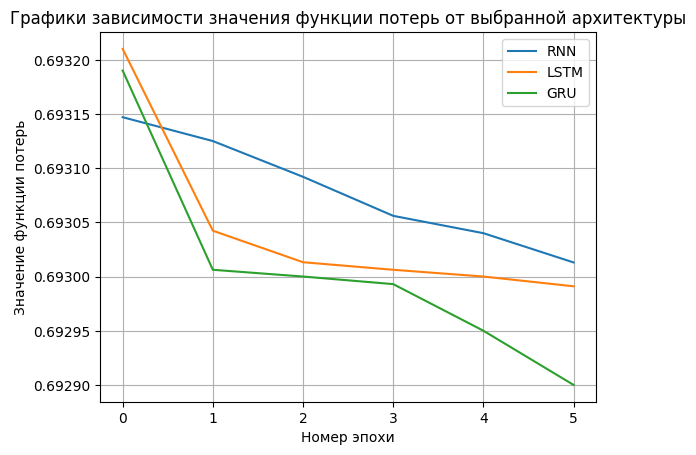

In [24]:
epoch_list = range(epochs + 1)

plt.plot(epoch_list, RNN_losses, label="RNN")
plt.plot(epoch_list, LSTM_losses, label="LSTM")
plt.plot(epoch_list, GRU_losses, label="GRU")

plt.title("Графики зависимости значения функции потерь от выбранной архитектуры")
plt.xlabel("Номер эпохи")
plt.ylabel("Значение функции потерь")
plt.grid(True)
plt.legend()
plt.show()

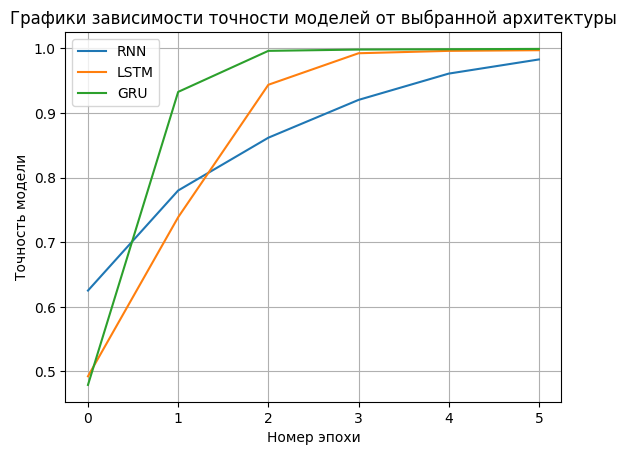

In [25]:
epoch_list = range(epochs + 1)

plt.plot(epoch_list, RNN_accs, label="RNN")
plt.plot(epoch_list, LSTM_accs, label="LSTM")
plt.plot(epoch_list, GRU_accs, label="GRU")

plt.title("Графики зависимости точности моделей от выбранной архитектуры")
plt.xlabel("Номер эпохи")
plt.ylabel("Точность модели")
plt.grid(True)
plt.legend()
plt.show()